In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from comet_ml import Experiment
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from  sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

In [81]:
experiment = Experiment(
    api_key="***",
    project_name="home_work_price_may",
    workspace="webbigail1",
    log_code=True
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/webbigail1/home-work-price-may/9da8dc99996746d3b68c81e3e27f0fdd



## Загрузка данных

In [82]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [83]:
data = pd.read_excel('data/data_ford_price.xlsx')

In [84]:
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [85]:
# Функция для кодирования методом OneHotEncoding

def encode_cat_features(columns_to_change, X_train, X_test, y_train):
    one_hot_encoder = OneHotEncoder()
    # Закодируем категориальные признаки
    X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
    X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

    # Результаты преобразуем обратно в DataFrame для удобства
    columns = one_hot_encoder.get_feature_names_out(columns_to_change)
    X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
    X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

    # Сбросим индексы таблиц
    X_train = X_train.reset_index().drop(['index'], axis = 1)
    X_test = X_test.reset_index().drop(['index'], axis = 1)
    y_train = y_train.reset_index().drop(['index'], axis = 1)

    # Добавим результаты кодирования к исходным таблицам
    X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
    X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
    
    # Удалим столбцы, которые уже были закодированы
    X_train_new = X_train_new.drop(columns=columns_to_change)
    X_test_new = X_test_new.drop(columns=columns_to_change)

    return X_train_new, X_test_new

## Предобработка данных

### Анализ мультколлинеарности

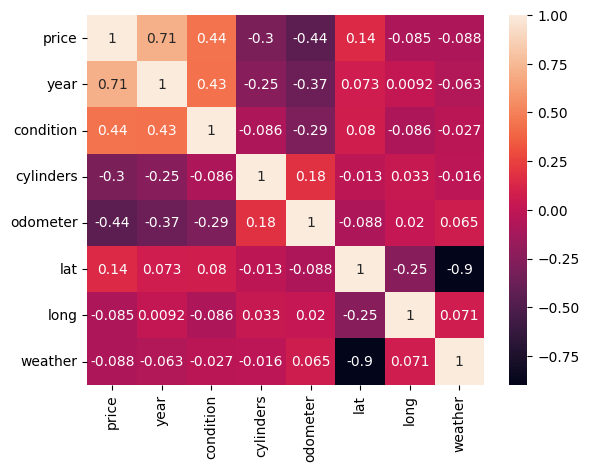

In [86]:
data_plot = sns.heatmap(data.corr(numeric_only=True), annot=True)

У признаков lat и weather присутствует сильная обратная связь, поэтому удалим lat, так как этот признак, в отличие от weather, необходимо округлять:

In [87]:
data.drop('lat', axis = 1, inplace = True)

### Разделяем:

In [88]:
y = data['price']
x = data.drop(columns='price')

### Общая статистика по числовым данным

In [89]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
year,7017.0,2007.869745,6.975329,1957.000000,2004.000000,2010.000000,2013.0000,2.018000e+03
condition,7017.0,2.598689,0.703662,0.000000,2.000000,3.000000,3.0000,5.000000e+00
cylinders,7017.0,7.374662,0.942928,3.000000,6.000000,8.000000,8.0000,1.000000e+01
odometer,7017.0,119978.670942,89922.155723,0.000000,73285.000000,118000.000000,157804.0000,2.490000e+06
long,7017.0,-91.903404,14.030710,-151.055832,-95.937145,-88.168416,-82.7063,-5.377999e+00
weather,6837.0,52.142899,7.954830,29.000000,45.000000,51.000000,59.0000,7.100000e+01


{'web': 'https://www.comet.com/api/image/download?imageId=34043782ab3a4a28b06b5169c7ede1dc&experimentKey=9da8dc99996746d3b68c81e3e27f0fdd',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=34043782ab3a4a28b06b5169c7ede1dc&experimentKey=9da8dc99996746d3b68c81e3e27f0fdd',
 'imageId': '34043782ab3a4a28b06b5169c7ede1dc'}

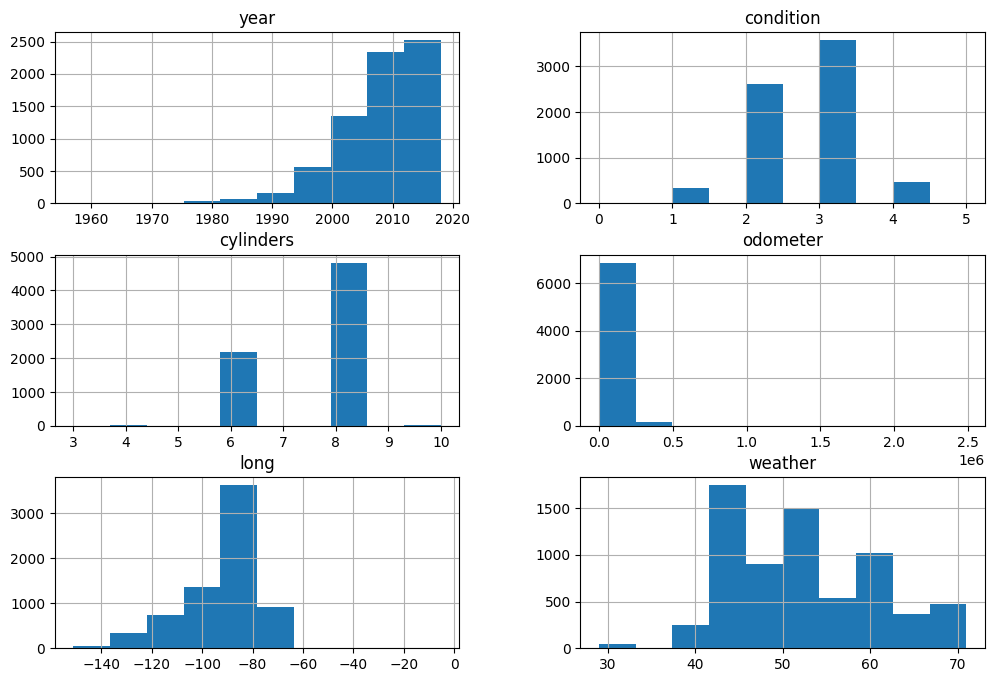

In [93]:
x.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_hist', plt)

* Видим пропуски в признаке weather(значение count меньше размера данных).
* Признаки condition и cylinders являются категориальными.

### Проверка на наличие пропусков и типов переменных

In [94]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          5453 non-null   object 
 8   long          7017 non-null   float64
 9   weather       6837 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 548.3+ KB


Типы в наших данных:
* 4 признака типа **object** - обычно это строковые значения;
* 4 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *drive, size и weather* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Заполнять пропуски будем с помощью ML.

#### weather
является непрерывным, поэтому используем линейную регрессию

In [95]:
# Скопируем данные в отдельную переменную
df = x.copy()
 
# В качестве тестовой выборки возьмем строки с пропусками в признаке weather
test_data = df[df['weather'].isnull()]
# И удалим эти строчки из таблицы
df.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = df['weather']
X_train = df.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

# Создадим кодировщик
one_hot_encoder = OneHotEncoder()
categorial_cols = ['cylinders', 'title_status', 'transmission', 'condition']

X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [96]:
model = LinearRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

In [97]:
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'weather'] = y_pred[i]

#### size, drive
Данные признаки являются категориальными. Следовательно, понадобится классификатор для заполения пропусков в них.

In [98]:
# Скопируем данные в отдельную переменную
df = x.copy()
 
# В качестве тестовой выборки возьмем строки с пропусками в признаке weather
test_data = df[df['size'].isnull()]
# И удалим эти строчки из таблицы
df.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = df['size']
X_train = df.drop(['size','drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)

X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [99]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

c:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'size'] = y_pred[i]

In [101]:
# Скопируем данные в отдельную переменную
df = x.copy()
 
# В качестве тестовой выборки возьмем строки с пропусками в признаке weather
test_data = df[df['drive'].isnull()]
# И удалим эти строчки из таблицы
df.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = df['drive']
X_train = df.drop(columns='drive')
X_test = test_data.drop(columns='drive')

categorial_cols = ['cylinders', 'title_status', 'transmission', 'condition', 'size']

X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [102]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

c:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'drive'] = y_pred[i]

In [104]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         7017 non-null   object 
 7   size          7017 non-null   object 
 8   long          7017 non-null   float64
 9   weather       7017 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 548.3+ KB


### Разделим выборки на тренировочные и тестовые

In [105]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

### Кодировка категориальных переменных

У нас 6 категориальных столбцов.

In [106]:
categorical_features = ['condition', 'cylinders', 'title_status', 
                        'transmission', 'drive', 'size']

**Label Encoding**

In [107]:
label_encoder = LabelEncoder()
X_train_le = X_train.copy()
X_test_le = X_test.copy()

for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

**One Hot Encoding**

In [108]:
X_train_oh, X_test_oh = encode_cat_features(categorical_features, X_train, X_test, y_train)

Построим модели на закодированных двумя разными способами данных.

In [109]:
model = LinearRegression()
model.fit(X_train_le, y_train)
y_predicted = model.predict(X_test_le)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4530.494


In [110]:
experiment.log_metric('MAE Label Encoding', mae)

In [111]:
model = LinearRegression()
model.fit(X_train_oh, y_train)
y_predicted = model.predict(X_test_oh)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4471.860


In [112]:
experiment.log_metric('MAE One Hot Encoding', mae)

One Hot Encoding показал немного лучший результат.

### Обработка выбросов в данных

Будем использовать Isolation Forest

*One Hot Encoding*

In [113]:
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
y_predicted = iso.fit_predict(X_train_oh)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train_oh, y_train_oh  = X_train_oh[mask], y_train[mask]
 
model = LinearRegression()
model.fit(X_train_oh, y_train_oh)
 
y_predicted = model.predict(X_test_oh)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4420.319


In [114]:
experiment.log_metric('MAE One Hot Encoding no outlier', mae)

*Label Encoding*

In [115]:
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
y_predicted = iso.fit_predict(X_train_le)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train_le, y_train_le = X_train_le[mask], y_train[mask]
 
model = LinearRegression()
model.fit(X_train_le, y_train_le)
 
y_predicted = model.predict(X_test_le)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4345.265


In [116]:
experiment.log_metric('MAE Label Encoding no outlier', mae)

На данных очищенных от выбросов лучший результат показывает метод порядкового кодирования, далее будем использовать эти данные. К тому же по причине того что количество признаков при порядковом кодировании не увеличивается нам дальше будет проще при отборе признаков.

##  Отбор признаков

### RFE

In [117]:
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_le, y_train_le)
 
selector.get_feature_names_out()

array(['condition', 'cylinders', 'transmission'], dtype=object)

In [118]:
X_train_le_rfe = X_train_le[['condition', 'cylinders', 'drive']]
X_test_le_rfe = X_test_le[['condition', 'cylinders', 'drive']]

In [119]:
model = LinearRegression()
model.fit(X_train_le_rfe, y_train_le)
 
y_predicted = model.predict(X_test_le_rfe)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 6829.761


In [120]:
experiment.log_metric('MAE Label Encoding no outlier rfe', mae)

### SelectKBest

In [121]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train_le, y_train_le)
 
selector.get_feature_names_out()

array(['year', 'condition', 'odometer'], dtype=object)

In [122]:
X_train_le_sb = X_train_le[['year', 'condition', 'odometer']]
X_test_le_sb = X_test_le[['year', 'condition', 'odometer']]

In [123]:
model = LinearRegression()
model.fit(X_train_le_sb, y_train_le)
 
y_predicted = model.predict(X_test_le_sb)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4655.909


In [124]:
experiment.log_metric('MAE Label Encoding no outlier selectkbest', mae)

#### **Вывод**

Если выбирать из методов отбора признаков, то SelectKBest показал существенно лучшие результаты по сравнению с RFE.

А в общем сокращение количества признаков привело к ухудшению показателей метрики. Самые лучшие результаты получились на очищенных от выбросов данных, закодированных методом порядкового кодирования *Label Encoding*.

In [125]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/webbigail1/home-work-price-may/9da8dc99996746d3b68c81e3e27f0fdd
COMET INFO:   Metrics:
COMET INFO:     MAE Label Encoding                        : 4530.49412355944
COMET INFO:     MAE Label Encoding no outlier             : 4345.264978476584
COMET INFO:     MAE Label Encoding no outlier rfe         : 6829.76090192289
COMET INFO:     MAE Label Encoding no outlier selectkbest : 4655.908798356063
COMET INFO:     MAE One Hot Encoding                      : 4471.859654610688
COMET INFO:     MAE One Hot Encoding no outlier           : 4420.31870963319
COMET INFO:   Parameters:
COMET INFO:     C                        : 1.0
COMET INFO:

COMET INFO:     criterion                : squared_error
COMET INFO:     drop                     : None
COMET INFO:     dtype                    : <class 'numpy.float64'>
COMET INFO:     dual                     : False
COMET INFO:     estimator                : LinearRegression()
COMET INFO:     estimator__copy_X        : True
COMET INFO:     estimator__fit_intercept : True
COMET INFO:     estimator__n_jobs        : None
COMET INFO:     estimator__positive      : False
COMET INFO:     feature_name_combiner    : concat
COMET INFO:     fit_intercept            : True
COMET INFO:     handle_unknown           : error
COMET INFO:     importance_getter        : auto
COMET INFO:     intercept_scaling        : 1
COMET INFO:     k                        : 3
COMET INFO:     l1_ratio                 : None
COMET INFO:     max_categories           : None
COMET INFO:     max_depth                : 8
COMET INFO:     max_features             : 1.0
COMET INFO:     max_iter                 : 1000
COM